In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


In [2]:
import tensorflow_addons as tfa

In [3]:
import wispy.resnet

In [4]:
def make_data(N=50):
    x = np.random.uniform(size=N)

    # y = 2 * np.sin(3.9*x) + 3 * np.sin(16*x)
    y = 2 * np.sin(3.9*x) + 3 * np.sin(16*x)
    

    return x.reshape(-1, 1), y.reshape(-1, 1)
    # return x.reshape(1, -1), y.reshape(1, -1)

In [5]:
x, y = make_data(N=500)
xval, yval = make_data(N=100)

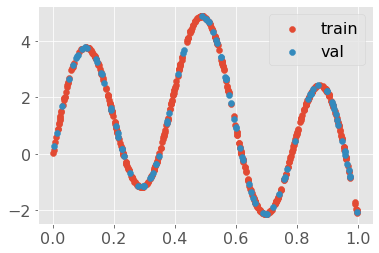

In [6]:
plt.figure()
plt.scatter(x, y, label='train')
plt.scatter(xval, yval, label='val')
plt.legend()

In [12]:
model = wispy.resnet.ResNet(
    input_shape=x.shape[1],
    output_shape=y.shape[1],
    width=128,
    num_blocks=2
)
model.compile(loss='mse', optimizer='adam')

In [13]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_183 (Dense)               (None, 128)          256         input_4[0][0]                    
__________________________________________________________________________________________________
group_normalization_183 (GroupN (None, 128)          256         dense_183[0][0]                  
__________________________________________________________________________________________________
activation_162 (Activation)     (None, 128)          0           group_normalization_183[0][0]    
____________________________________________________________________________________________

In [14]:
%%time
callbacks = []
callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, min_lr=1e-5))

tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history = model.fit(x, y, validation_data=(xval, yval), epochs=2000, batch_size=500, validation_batch_size=100, verbose=0, callbacks=callbacks)

Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

CPU times: user 2min 56s, sys: 28.7 s, total: 3min 24s
Wall time: 1min 53s


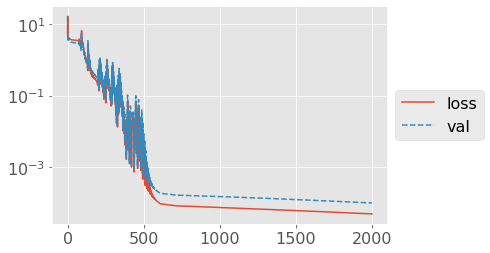

In [15]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val', ls='--')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

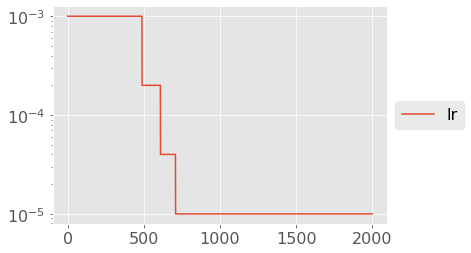

In [16]:
plt.figure()
plt.plot(history.history['lr'], label='lr')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

Text(0.5, 1.0, 'training')

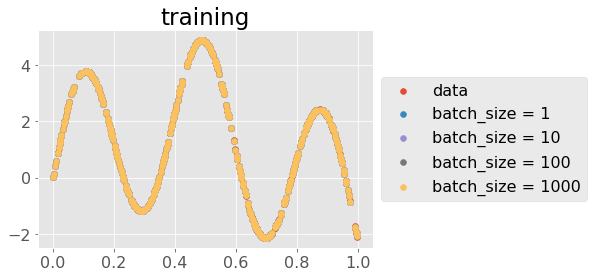

In [17]:
plt.figure()
plt.scatter(x, y, label='data')
plt.scatter(x, model.predict(x, batch_size=1), label='batch_size = 1')
plt.scatter(x, model.predict(x, batch_size=10), label='batch_size = 10')
plt.scatter(x, model.predict(x, batch_size=100), label='batch_size = 100')
plt.scatter(x, model.predict(x, batch_size=1000), label='batch_size = 1000')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('training')

Text(0.5, 1.0, 'training')

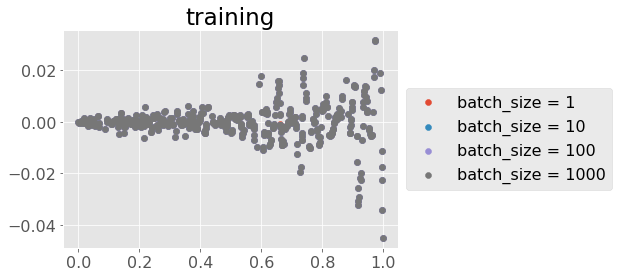

In [18]:
plt.figure()
plt.scatter(x, y-model.predict(x, batch_size=1), label='batch_size = 1')
plt.scatter(x, y-model.predict(x, batch_size=10), label='batch_size = 10')
plt.scatter(x, y-model.predict(x, batch_size=100), label='batch_size = 100')
plt.scatter(x, y-model.predict(x, batch_size=1000), label='batch_size = 1000')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('training')

Text(0.5, 1.0, 'validation')

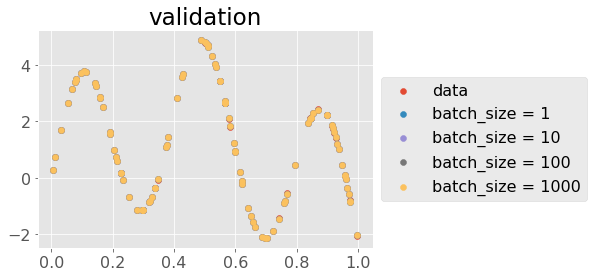

In [19]:
plt.figure()
plt.scatter(xval, yval, label='data')
plt.scatter(xval, model.predict(xval, batch_size=1), label='batch_size = 1')
plt.scatter(xval, model.predict(xval, batch_size=10), label='batch_size = 10')
plt.scatter(xval, model.predict(xval, batch_size=100), label='batch_size = 100')
plt.scatter(xval, model.predict(xval, batch_size=1000), label='batch_size = 1000')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('validation')

Text(0.5, 1.0, 'validation')

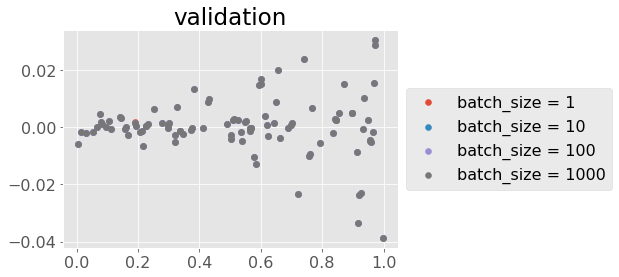

In [20]:
plt.figure()
plt.scatter(xval, yval-model.predict(xval, batch_size=1), label='batch_size = 1')
plt.scatter(xval, yval-model.predict(xval, batch_size=10), label='batch_size = 10')
plt.scatter(xval, yval-model.predict(xval, batch_size=100), label='batch_size = 100')
plt.scatter(xval, yval-model.predict(xval, batch_size=1000), label='batch_size = 1000')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('validation')

# comparison to a 'plain' network

In [21]:
def build_base_model(input_shape, output_shape, width, depth):
    inputs = keras.Input(shape=(input_shape,))

    x = layers.Dense(width, 'relu')(inputs)
    for i in range(depth):
        x = layers.Dense(width, 'relu')(x)

    outputs = layers.Dense(output_shape)(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name=f"base_model")

    return model

In [41]:
model_base = build_base_model(input_shape=x.shape[1], output_shape=y.shape[1], width=int(128), depth=19)
model_base.compile(loss='mse', optimizer='adam')

In [42]:
model_base.summary()

Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_386 (Dense)            (None, 128)               256       
_________________________________________________________________
dense_387 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_388 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_389 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_390 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_391 (Dense)            (None, 128)               1

In [43]:
%%time
callbacks = []
callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, min_lr=1e-5))

tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_base = model_base.fit(x, y, validation_data=(xval, yval), epochs=2000, batch_size=500, validation_batch_size=100, verbose=0, callbacks=callbacks)

Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

CPU times: user 2min 18s, sys: 19.5 s, total: 2min 38s
Wall time: 1min 28s


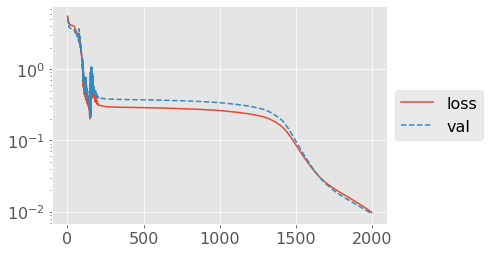

In [44]:
plt.figure()
plt.plot(history_base.history['loss'], label='loss')
plt.plot(history_base.history['val_loss'], label='val', ls='--')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

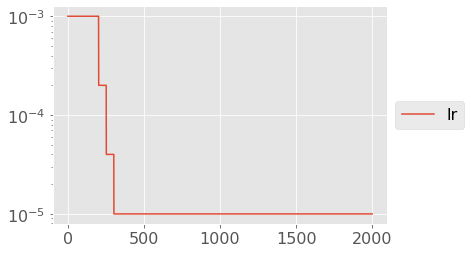

In [45]:
plt.figure()
plt.plot(history_base.history['lr'], label='lr')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

Text(0.5, 1.0, 'training')

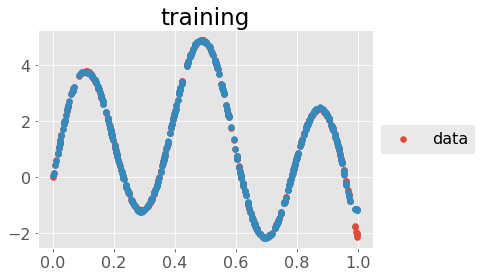

In [46]:
plt.figure()
plt.scatter(x, y, label='data')
plt.scatter(x, model_base.predict(x))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('training')

Text(0.5, 1.0, 'training')

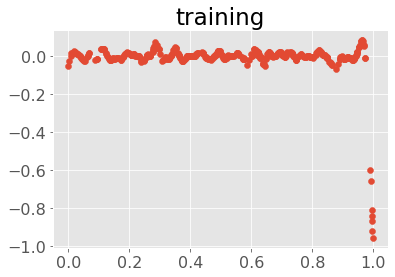

In [47]:
plt.figure()
plt.scatter(x, y-model_base.predict(x))
plt.title('training')

Text(0.5, 1.0, 'validation')

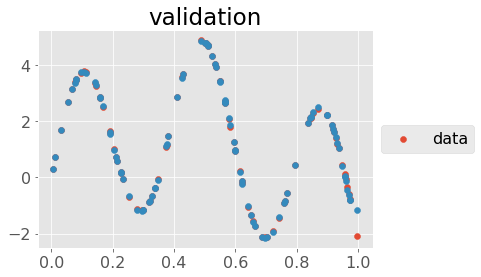

In [48]:
plt.figure()
plt.scatter(xval, yval, label='data')
plt.scatter(xval, model_base.predict(xval))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('validation')

Text(0.5, 1.0, 'validation')

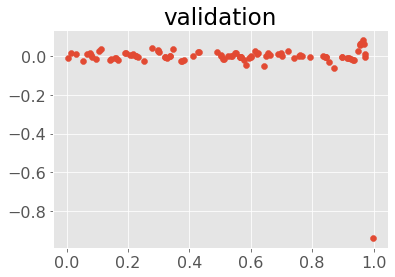

In [49]:
plt.figure()
plt.scatter(xval, yval-model_base.predict(xval))
plt.title('validation')

# comparison

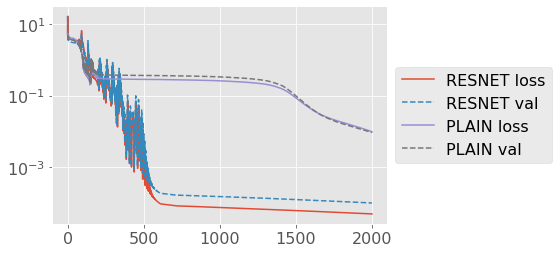

In [52]:
plt.figure()

plt.plot(history.history['loss'], label='RESNET loss')
plt.plot(history.history['val_loss'], label='RESNET val', ls='--')

plt.plot(history_base.history['loss'], label='PLAIN loss')
plt.plot(history_base.history['val_loss'], label='PLAIN val', ls='--')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

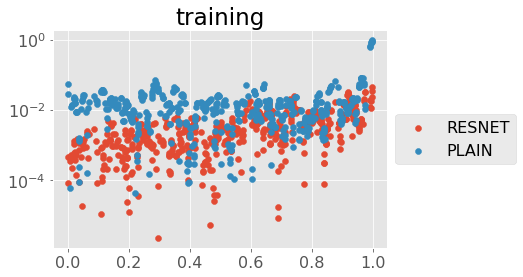

In [61]:
plt.figure()
plt.scatter(x, np.abs(y-model.predict(x)), label='RESNET')
plt.scatter(x, np.abs(y-model_base.predict(x)), label='PLAIN')
plt.title('training')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

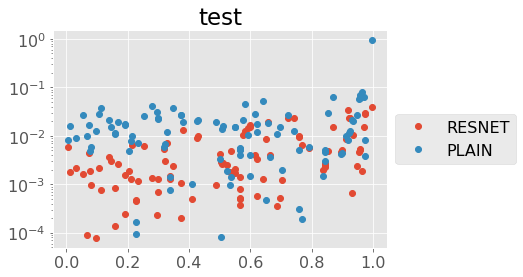

In [59]:
plt.figure()
plt.plot(xval, np.abs(yval-model.predict(xval)), 'o', label='RESNET')
plt.plot(xval, np.abs(yval-model_base.predict(xval)), 'o', label='PLAIN')
plt.title('test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')